# Getting information from SBML PBK model files

This notebook demonstrates how information can be obtained from a PBK model stored in the SBML format using the EuroMix PBK model SBML model as example.

## Preparation

In [1]:
import pandas as pd
import libsbml as ls
from tabulate import tabulate

In [2]:
# Specify sbml file path
sbml_file = '../model/euromix.sbml'

## Parsing the model

### General SBML file format checks

In [3]:
# Open SBML document using libSBML
document = ls.readSBML(sbml_file)

# Check for errors
if document.getNumErrors() > 0:
    print("Encountered " + str(document.getNumErrors()) + " SBML errors:" )
    document.printErrors()

# Get SBML level and version and print
level = document.getLevel()
version = document.getVersion()
print("\n"
      + "File: " + sbml_file
      + " (Level " + str(level) + ", version " + str(version) + ")" )

# Get the model
model = document.getModel()

if model is None:
    print("No model present." )


File: ../model/euromix.sbml (Level 3, version 1)


### Describe compartments

Each compartment should be linked to a compartment matching the vocabulary of the to-be-developed PBK modelling ontology. For each compartment, the unit of measurement of the volume should be specified.

In [4]:
# Helper function to extract is-a resource URI
def getTerm(element):
    cvTerms = element.getCVTerms()
    if not cvTerms:
        return None

    for term in cvTerms:
      num_resources = term.getNumResources()
      for j in range(num_resources):
          if term.getQualifierType() == ls.BIOLOGICAL_QUALIFIER and \
              term.getBiologicalQualifierType() == ls.BQB_IS:
              return term.getResourceURI(j)

    return None 

def getUnitString(element):
    # TODO: produce some more humanly readible unit strings
    return ls.UnitDefinition.printUnits(element.getDerivedUnitDefinition())

# Create compartments info table
print("Compartments (" + str(model.getNumCompartments()) + ")")
dt_compartments = []
for i in range(0,model.getNumCompartments()):
    c = model.getCompartment(i)
    dt_compartments.append([
        c.getId(),
        c.getName(),
        c.getVolume(),
        getUnitString(c),
        getTerm(c)
    ])
df_compartments = pd.DataFrame(
    dt_compartments,
    columns=["Id", "Name", "Volume", "Unit", "URI"]
)
print(tabulate(df_compartments, headers="keys", tablefmt="fancy_grid", showindex=False))

Compartments (12)
╒═════════════════════╤════════╤══════════╤═════════════════════════════════════════════════╤═══════════════════════════════════════╕
│ Id                  │ Name   │   Volume │ Unit                                            │ URI                                   │
╞═════════════════════╪════════╪══════════╪═════════════════════════════════════════════════╪═══════════════════════════════════════╡
│ default_compartment │        │  1       │ litre (exponent = 1, multiplier = 1, scale = 0) │ http://identifiers.org/SBO:0000290    │
├─────────────────────┼────────┼──────────┼─────────────────────────────────────────────────┼───────────────────────────────────────┤
│ Fat                 │        │ 14.63    │ litre (exponent = 1, multiplier = 1, scale = 0) │ http://identifiers.org/UBERON:0001013 │
├─────────────────────┼────────┼──────────┼─────────────────────────────────────────────────┼───────────────────────────────────────┤
│ Rich                │        │  7.35    │ 

### Describe substances (chemical species)

Each species should represent a substance concentration/amount of a chemical substance in one of the compartments. For each species, the unit of measurement of the concentration/amount should be specified.

In [5]:
# Create species info table
dt_species = []
print("Number of species: " + str(model.getNumSpecies()))
for i in range(0,model.getNumSpecies()):
    s = model.getSpecies(i)
    dt_species.append([
        s.getId(),
        s.getName(),
        s.getCompartment(),
        getUnitString(s)
    ])
df_species = pd.DataFrame(
    dt_species,
    columns=["Id", "Name", "IdCompartment", "Unit"]
)
print(tabulate(df_species, headers="keys", tablefmt="fancy_grid", showindex=False))

Number of species: 14
╒════════════╤════════╤═════════════════════╤═══════════════════════════════════════════════════════════════════════════════════════════════════╕
│ Id         │ Name   │ IdCompartment       │ Unit                                                                                              │
╞════════════╪════════╪═════════════════════╪═══════════════════════════════════════════════════════════════════════════════════════════════════╡
│ QFat       │        │ Fat                 │ mole (exponent = 1, multiplier = 1, scale = -3)                                                   │
├────────────┼────────┼─────────────────────┼───────────────────────────────────────────────────────────────────────────────────────────────────┤
│ QRich      │        │ Rich                │ mole (exponent = 1, multiplier = 1, scale = -3)                                                   │
├────────────┼────────┼─────────────────────┼─────────────────────────────────────────────────────────

### Describe parameters

The unit for each parameter should be specied. Unitless parameters should be explicitly specified as such. Each parameter should be associated with the correct ontological term(s) that exactly identify the type of parameter so that it becomes possible to search for the parameter value in databases. How to accomplish this is yet unclear?

In [6]:
# Create parameters info table
dt_params = []
print("Number of parameters: " + str(model.getNumParameters()))
for i in range(0,model.getNumParameters()):
    s = model.getParameter(i)
    dt_params.append([
        s.getId(),
        s.getName(),
        getUnitString(s),
        getTerm(s)
    ])
df_params = pd.DataFrame(
    dt_params,
    columns=["Id", "Name", "Unit", "URI"]
)
print(tabulate(df_params, headers="keys", tablefmt="fancy_grid", showindex=False))

Number of parameters: 51
╒═════════════╤════════╤═════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╤═════════════════════════════════════════════╕
│ Id          │ Name   │ Unit                                                                                                                                                    │ URI                                         │
╞═════════════╪════════╪═════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╪═════════════════════════════════════════════╡
│ BM          │        │ gram (exponent = 1, multiplier = 1, scale = 3)                                                                                                          │ http://purl.obolibrary.org/obo/NCIT_C81328  │
├─────────────┼────────┼───────────────────────────────────────────────────

### Render the differential equations

Script below renders the differential equations of the model in simple text format. Would nice to get some latex formatting for this as well.

In [7]:
# Get the list of species IDs
species_ids = [species.getId() for species in model.getListOfSpecies()]

# Initialize dictionaries to store the differential equations and reaction rates
differential_equations = {}
reaction_rates = {}

# Iterate over the reactions in the model
for i in range(model.getNumReactions()):
    reaction = model.getReaction(i)
    
    # Get the kinetic law associated with the reaction
    kinetic_law = reaction.getKineticLaw()
    if kinetic_law is None:
        continue
    
    # Get the reaction rate formula
    rate_formula = ls.formulaToString(kinetic_law.getMath())
    
    # Iterate over the reactants and products of the reaction
    for j in range(reaction.getNumReactants()):
        reactant = reaction.getReactant(j)
        species_id = reactant.getSpecies()
        
        # Add the reaction rate to the dictionary
        if species_id in reaction_rates:
            reaction_rates[species_id].append(f"- {rate_formula}")
        else:
            reaction_rates[species_id] = [f"- {rate_formula}"]
    
    for j in range(reaction.getNumProducts()):
        product = reaction.getProduct(j)
        species_id = product.getSpecies()
        
        # Add the negative reaction rate to the dictionary
        if species_id in reaction_rates:
            reaction_rates[species_id].append(rate_formula)
        else:
            reaction_rates[species_id] = [rate_formula]

# Construct the differential equations for each species
for species_id in species_ids:
    if species_id in reaction_rates:
        new_line = '\n'
        pref = f'{new_line}{" " * (len(species_id) + 8)}'
        equation = f"d[{species_id}]/dt = {f'{pref} + '.join(reaction_rates[species_id])}"
        differential_equations[species_id] = equation.replace("+ -", "-")

# Print the differential equations for each species
for species_id, equation in differential_equations.items():
    print(equation)

d[QFat]/dt = FFat * conc(QArt, Art)
             - FFat * conc(QFat, Fat) / PCFat
d[QRich]/dt = FRich * conc(QArt, Art)
              - FRich * conc(QRich, Rich) / PCRich
d[QPoor]/dt = FPoor * conc(QArt, Art)
              - FPoor * conc(QPoor, Poor) / PCPoor
d[QLiver]/dt = FLiver * conc(QArt, Art)
               - FLiver * conc(QLiver, Liver) / PCLiver
               + kGut * QGut
               - fub * piecewise(metab_MM(Vmax, Km, PCLiver, QLiver, Liver), gt(Michaelis, 0.5), metab_MA(CLH, PCLiver, QLiver, Liver))
d[QMetab]/dt = fub * piecewise(metab_MM(Vmax, Km, PCLiver, QLiver, Liver), gt(Michaelis, 0.5), metab_MA(CLH, PCLiver, QLiver, Liver))
d[QGut]/dt = - kGut * QGut
d[QSkin_u]/dt = FSkin_u * conc(QArt, Art)
                - FSkin_u * conc(QSkin_u, Skin_u) / PCSkin
                - f_su * conc(QSkin_u, Skin_u) / PCSkin_sc
                + f_su * conc(QSkin_sc_u, Skin_sc_u)
d[QSkin_e]/dt = FSkin_e * conc(QArt, Art)
                - FSkin_e * conc(QSkin_e, Skin_e) / PCSkin
    

### Render model diagram

Would be nice to be able to automatically generate the model diagram. The SBMLDiagrams package makes an effort, but it is not really satisfactory.

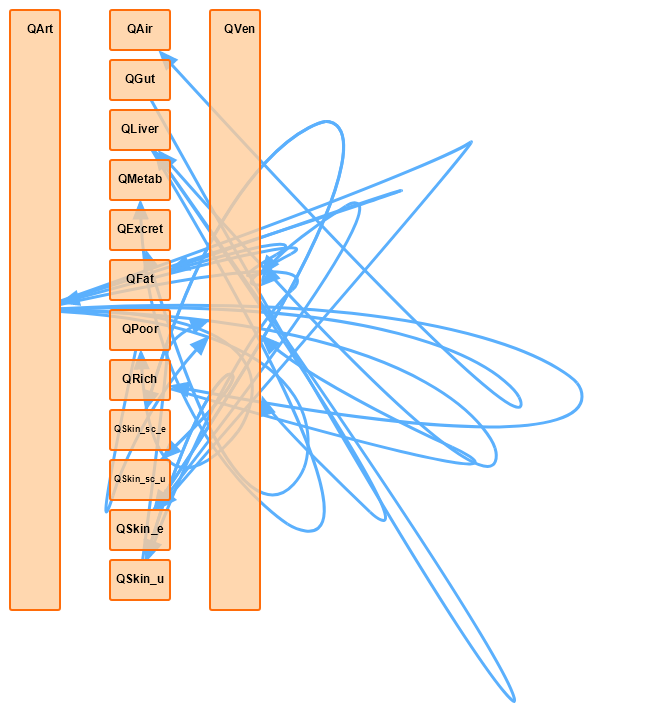

In [8]:
import SBMLDiagrams
df = SBMLDiagrams.load(sbml_file)
#df.autolayout()
df.setNodeAndTextPosition('QVen', [300, 50])
df.setNodeSize('QVen', [50, 600])
df.setNodeAndTextPosition('QArt', [100, 50])
df.setNodeSize('QArt', [50, 600])
df.setNodeAndTextPosition('QAir', [200, 50])
df.setNodeAndTextPosition('QGut', [200, 100])
df.setNodeAndTextPosition('QLiver', [200, 150])
df.setNodeAndTextPosition('QMetab', [200, 200])
df.setNodeAndTextPosition('QExcret', [200, 250])
df.setNodeAndTextPosition('QFat', [200, 300])
df.setNodeAndTextPosition('QPoor', [200, 350])
df.setNodeAndTextPosition('QRich', [200, 400])
df.setNodeAndTextPosition('QSkin_sc_e', [200, 450])
df.setNodeAndTextPosition('QSkin_sc_u', [200, 500])
df.setNodeAndTextPosition('QSkin_e', [200, 550])
df.setNodeAndTextPosition('QSkin_u', [200, 600])
df.draw()


## Export annotation template

To make model annotation a bit easier, we could create an annotation template. The code below demonstrates how we could do this.

In [9]:
df_compartments['sbml_type'] = 'compartment'
df_species['sbml_type'] = 'species'
df_params['sbml_type'] = 'parameter'
df_annotations = pd.concat(
    [
        df_compartments[['Id', 'sbml_type','Name', 'Unit']],
        df_species[['Id', 'sbml_type','Name', 'Unit']],
        df_params[['Id', 'sbml_type','Name', 'Unit']]
    ],
)
df_annotations.columns=['id', 'sbml_type','name', 'unit']
df_annotations['pattern'] = df_annotations['id']
df_annotations.insert(5, 'annotation_type', 'rdf')
df_annotations.insert(6, 'qualifier', 'BQB_IS')
df_annotations.insert(7, 'resource', '')
df_annotations.to_csv('euromix.annotations.csv', index=False)
df_annotations


,id,sbml_type,name,unit,pattern,annotation_type,qualifier,resource
0,default_compartment,compartment,,"litre (exponent = 1, multiplier = 1, scale = 0)",default_compartment,rdf,BQB_IS,
1,Fat,compartment,,"litre (exponent = 1, multiplier = 1, scale = 0)",Fat,rdf,BQB_IS,
2,Rich,compartment,,"litre (exponent = 1, multiplier = 1, scale = 0)",Rich,rdf,BQB_IS,
3,Poor,compartment,,"litre (exponent = 1, multiplier = 1, scale = 0)",Poor,rdf,BQB_IS,
4,Liver,compartment,,"litre (exponent = 1, multiplier = 1, scale = 0)",Liver,rdf,BQB_IS,
...,...,...,...,...,...,...,...,...
46,FLiver,parameter,,"litre (exponent = 1, multiplier = 1, scale = 0...",FLiver,rdf,BQB_IS,
47,FSkin,parameter,,"litre (exponent = 1, multiplier = 1, scale = 0...",FSkin,rdf,BQB_IS,
48,FRich,parameter,,"litre (exponent = 1, multiplier = 1, scale = 0...",FRich,rdf,BQB_IS,
49,FSkin_e,parameter,,"litre (exponent = 1, multiplier = 1, scale = 0...",FSkin_e,rdf,BQB_IS,
